`이 자료의 모든 내용은 본인이 직접 작성하였습니다.`

# Autograd의 원리를 수동으로 구현하고 최적화하기

---


## 0. 기초 이론 정리

### 도함수(Jacobian)

다변수 함수의 도함수(Jacobian)는 $\frac{\partial \mathbf{F}}{\partial\mathbf{x}}$ 로 표기하며 **가능한 모든 편미분값 $\frac{\partial F_i}{\partial x_j}$ 를 원소로 갖는 텐서**로 생각할 수 있다.

다시 말해서, $\mathbf{F}$ 와 $\mathbf{x}$ 는 각각 1차원씩의 자유도를 갖는(흔히 말하는 벡터의 유클리드 차원 개념과는 다름) 1-텐서(벡터)이고, 그것의 도함수는 해당 1-텐서 두개의 가능한 모든 원소들의 조합을 가지므로, **다음과 같은 6개 원소를 갖는 2-텐서이다:**

$$ \left(\frac{\partial \mathbf{F}}{\partial\mathbf{x}}\right)_{i,j} = \frac{\partial F_i}{\partial x_j}, \qquad(i=1,2,\;j = 1,2,3) .$$

하나 더 추가할 점은, 이제부터는 미분을 하는 변수의 index는 아래 첨자로, 미분이 되는 변수(함수)의 index는 위 첨자로 

$$ \left(\frac{\partial \mathbf{F}}{\partial\mathbf{x}}\right)^{\color{red}i}_{\color{red}j} = \frac{\partial F^{\color{red}i}}{\partial x_{\color{red}j}}$$

와 같이 쓴다.

물리학과 미분기하학에서는 해당 텐서의 위 첨자에 표시한 차원은 '반변(contravariant)성분', 아래 첨자에 표시한 차원은 '공변(covariant)성분'이라고 부르며, 이는 곧 언급할 체인 룰의 계산에 필요한 **아인슈타인 합의 규약(Einstein Summation Convention)** 이라는 특수한 형태의 텐서 수축 표기와 관련이 있다.

이제, 더 나아가 어떤 $n$-텐서 $\mathbf{S}$ 를 변수로 갖는 $m$-텐서함수 $\mathbf{T}(\mathbf{S})$ 를 생각해보면, 역시 $\mathbf{T}$ 의 $\mathbf{S}$ 에 대한 도함수도 정의할 수 있는데, 그것은 $\mathbf{T}$ 의 모든 원소들을 $\mathbf{S}$ 의 모든 원소들로 편미분한 값들을 원소로 가져야 하므로 $(m+n)$-텐서가 되며 그것의 각 원소들은

>$$ \left(\frac{\partial}{\partial\mathbf{S}} \mathbf{T}(\mathbf{S})\right)^{i_1,\dots,i_m}_{j_1,\dots,j_n} = \frac{\partial\mathbf{T}^{i_1,\dots,i_m}}{\partial \bf{S}_{j_1,\dots,j_n}} $$

로 쓸 수 있다.

### 텐서의 수축(Contraction)

수축(Contraction)은, 두 텐서 사이의 연산이며 **같은 갯수의 원소를 갖는 차원끼리 점곱(dot product)를 실시하는 연산** 으로, 벡터들 사이의 점곱을 텐서에 확장한 개념으로 볼 수 있다. 먼저, *같은 길이의* 두 벡터 $\mathbf{a}=(\mathbf{a}_{i})$ 와 $\mathbf{b} = (\mathbf{b}_j)$ ($i,j=1,\dots,N$) 사이의 점곱은 엄밀하게 다음과 같이 쓸 수 있다.

\begin{align}
\mathbf{a}\cdot\mathbf{b} & = \sum_{i,j} \delta_{i,j}\mathbf{a}_i \mathbf{b}_j.
\end{align}

여기서, $\delta_{i,j}$ 는 Kronecker-delta ($i=j$ 이면 1을, $i\not=j$ 이면 0을 원소로 갖는 일종의 2-텐서) 표기이다. 즉, 같은 인덱스의 원소끼리만 곱해준 뒤 각각을 더해준다는 의미이다. 2중합 $\sum_{i,j}$는, Kronecker-delta의 영향으로 $i=j$ 일때만 고려하면 되므로 다음과 같이 더 친숙한 표현으로 바뀐다.

$$\mathbf{a}\cdot\mathbf{b} = \sum_{i} \mathbf{a}_i \mathbf{b}_i. $$

이 벡터 점곱의 개념을 텐서 개념에 확장하면, 다음과 같이 쓸 수 있다: 

두 $m$-, $n$-텐서
$(\mathbf{T})_{i_0,i_1,\dots,i_{m-1}},\;\; (\mathbf{S})_{j_0,j_1,\dots,j_{n-1}}$ 에 대해, 각각의 index들을 집합표현으로 간단히 $I = \{i_0,i_1,\dots,i_{m-1}\}$, $J=\{j_0,j_1,\dots,j_{n-1}\}$ 로 나타내보자. 서로 점곱을 해 줄 차원을 지정해주는 $d$ 개의 index 쌍들의 집합을 $\sigma=\{i_{m_k},j_{n_k}\}_{k=0}^{d-1} $ 로 나타낸다면, $\mathbf{T}$ 와 $\mathbf{S}$ 사이의 $\sigma$ index 끼리의 점곱에 의한 수축은 새로운 텐서를 만들고, 그것의 각 성분들은 구체적으로 다음과 같이 정의됨을 알 수 있다:

$$ (\mathbf{T} \bullet_{\sigma} \mathbf{S})_{(I\cup J)\setminus\sigma} = \sum_{i_{m_0},j_{n_0},\dots,i_{m_{d-1}},j_{m_{d-1}}} \delta_{i_{m_0},j_{n_0}}\delta_{i_{m_1},j_{n_1}}\cdots \delta_{i_{m_{d-1}},j_{m_{d-1}}}\mathbf{T}_{i_0,i_1,\dots,i_{m-1}}\mathbf{S}_{j_0,j_1,\dots,j_{n-1}}. \quad\quad\quad\cdots\;(*)$$

**(점곱을 해 줄 index의 차원끼리는 원소의 갯수가 맞아야 합니다.)** 벡터(1차원 텐서)끼리의 점곱이 $1+1-2 = 0$ 에 의해 스칼라(0차원 텐서)를 반환하듯이, $m$-텐서와 $n$-텐서의 $d$ 개의 차원들에 대한 점곱($\sigma$ 집합으로 지시해준)에 의한 수축은 인덱스 집합으로 $(I\cup J)\setminus\sigma$ 를 갖는 새로운 $m+n-2d$ 차원의 텐서를 만든다. 

우리가 흔히 아는 행렬과 행렬의 곱셈도 결국 2차원 텐서끼리의 1개 차원의 수축으로 표현할 수 있습니다. 어떤 두 $M_0\times M_1$, $N_0\times N_1$ 행렬 $(\mathbf{A})_{i_0,i_1}$ 와 $(\mathbf{B})_{j_0,j_1}$ 의 행렬곱 $\mathbf{A}\mathbf{B}$는 $M_1 = N_0$ 일 때만 정의되며, 결과는 $M_0\times N_1$ 행렬인 것을 떠올려 보면,

\begin{align}
(\mathbf{A}\mathbf{B})_{i_0,j_1} & = \sum_{k}\mathbf{A}_{i_0,k}\mathbf{B}_{k,j_1} \\
& = \sum_{i_1,j_0}\delta_{i_1,j_0}\mathbf{A}_{i_0,i_1}\mathbf{B}_{j_0,j_1} \\
& = (\mathbf{A}\; \bullet_{\{i_1,j_0\}} \;\mathbf{B})_{i_0,j_1},
\end{align}

즉, $\mathbf{A}\mathbf{B} = \mathbf{A}\; \bullet_{\{i_1,j_0\}} \;\mathbf{B}$ 로써 행렬곱은 첫 번째 행렬의 행과 두 번째 행렬의 열 끼리 점곱을 실시하는, 위 $(*)$ 식의 특별한 경우임을 알 수 있다.

### 체인 룰과 아인슈타인 표기

이제, $\mathbf{T}$ 를 미분했던 텐서 $\mathbf{S}$ 가 다른 $l$-텐서 $(\mathbf{U})_{k_1,\dots,k_l}$ 에 대한 함수였다고 가정해보자. 그러면, $\mathbf{T}$ 의 $\mathbf{U}$ 에 대한 도함수 텐서는, $(m+l)$-텐서이고, 다음과 같이 표현된다:

>$$ \left(\frac{\partial}{\partial\mathbf{U}}\mathbf{T}(\mathbf{S}(\mathbf{U}))\right)^{i_1,\dots,i_m}_{k_1,\dots,k_l} = \sum_{\color{red}j_1,\dots,j_n}\frac{\partial \mathbf{T}^{i_1,\dots,i_m}}{\partial \mathbf{S}_{\color{red}j_1,\dots,j_n}}\;\frac{\partial \mathbf{S}^{\color{red}j_1,\dots,j_n}}{\partial \mathbf{U}_{k_1,\dots,k_l}}. \qquad\qquad\cdots \;(**)$$
>
>**이것이 일반적인 형태의 체인 룰이며, 두 도함수 텐서 $\frac{\partial\mathbf{T}}{\partial\mathbf{S}}$ 와 $\frac{\partial\mathbf{S}}{\partial\mathbf{U}}$ 의 $\mathbf{S}$ 의 성분에 해당하는 index 끼리의 수축**이다.


쉬운 예로, 앞서 정의한 벡터장 함수 $\mathbf{F}$ 의 각 변수들, $x_1$ 그리고 $x_2$, $x_3$ 가 다시 $t$ 라는 스칼라 변수에 대한 함수였다고 가정해 보자. 그러면 체인 룰에 의해, 1-텐서 $\mathbf{F}$ 를 0-텐서 $t$에 대해 미분한 결과는 $1+0=1$ 텐서이며, 그 원소들을 $i$ 로 인덱싱 하면 아인슈타인 표기에 의해:

$$
\left(\frac{\partial}{\partial t} \mathbf{F}(\mathbf{x}(t))\right)^i =  \left(\frac{\partial}{\partial \mathbf{x}} \mathbf{F}(\mathbf{x})\right)^i_{\color{red}j}\;\left(\frac{\partial}{\partial t}\mathbf{x}(t)\right)^{\color{red}j} \\
\!\!\!\!= \frac{\partial F_i}{\partial x_{\color{red}j}} \frac{\partial x_{\color{red}j}}{\partial t} \\
\qquad\qquad\qquad\qquad\qquad\qquad\,\;\;\;\;\;= \frac{\partial F_i}{\partial x_1}\frac{\partial x_1}{\partial t} + \frac{\partial F_i}{\partial x_2}\frac{\partial x_2}{\partial t}+ \frac{\partial F_i}{\partial x_3}\frac{\partial x_3}{\partial t}, \quad i = 1,2
$$

가 된다. 이는 $\mathbf{F}$ 의 각 성분별로 기본적인 체인 룰을 적용한 결과다.

---

### Feed-Forward Network와 체인 룰

연습삼아,

- 가중치행렬 $\mathbf{W}$ 와 바이어스 벡터 $\mathbf{b}$ 를 파라미터로 갖고 시그모이드 함수 $\Phi(\mathbf{x}) = [\phi(x_1)\;\phi(x_2\;)\;\dots\;\;]$ 를 activation으로 갖는 하나의 퍼셉트론 변환

$$ \mathcal{L}(\mathbf{x};\mathbf{W},\mathbf{b}) = \Phi(\mathbf{x}\mathbf{W}+\mathbf{b}) $$

을 가중치 행렬 파라미터 $\mathbf{W}$ 에 대해 미분을 해 보면,

이 레이어 함수는 다음 레이어로 넘길 다른 벡터를 반환하는 벡터(1-텐서)함수이고, $\mathbf{W}$ 는 2-텐서 이므로 이 도함수 $\frac{\partial}{\partial \mathbf{W}}\mathcal{L}(\mathbf{x};\mathbf{W},\mathbf{b})$는 $1+2=3$-텐서가 됨을 알 수 있다. 여기서, $\mathbf{W}\mathbf{x}+\mathbf{b} = \mathbf{h}$ 로 표기하면, 아인슈타인 표기를 적용한 체인 룰에 의해

$$ \left(\frac{\partial}{\partial\mathbf{W}}\mathcal{L}(\mathbf{x};\mathbf{W},\mathbf{b})\right)^i_{jk}= \left(\frac{\partial}{\partial\mathbf{h}}\Phi(\mathbf{h})\right)^i_{\color{red}l}\;\left(\frac{\partial}{\partial \mathbf{W}}(\mathbf{W}\mathbf{x}+\mathbf{b})\right)^{\color{red}l}_{jk} $$

로 쓸 수 있고, 각각의 도함수 텐서는 세부적으로 다음과 같이 계산된다:

\begin{align}
\left(\frac{\partial}{\partial\mathbf{h}}\Phi(\mathbf{h})\right)^i_{l} & = \frac{\partial}{\partial h^l} \phi(h^i) = \phi'(h^i)\delta^i_l, \\
\left(\frac{\partial}{\partial \mathbf{W}}(\mathbf{x}\mathbf{W}+\mathbf{b})\right)^{l}_{jk} & = \frac{\partial}{\partial W_{jk}} (x_n W^{nl}  + b^l) = \delta_{nj}\delta_k^l x^n = \delta^l_k x^j \;\;(\;\because \;\delta_{nj}x^n=x^j).
\end{align}

따라서, 

\begin{align}
\left(\frac{\partial}{\partial\mathbf{W}}\mathcal{L}(\mathbf{x};\mathbf{W},\mathbf{b})\right)^i_{jk} & = \phi'(h^i)x^j\delta^i_l\delta^l_k \\
& = \phi'(h^i) x^j \delta^i_k
\end{align}

이 된다. 이 때, sigmoid 함수의 도함수 $\phi'(x)$ 는 $\phi(x)(1-\phi(x))$ 임이 잘 알려져 있으므로, 더 간단히는

$$ = \phi(h^i)(1-\phi(h^i))x^j\delta^i_k  $$

로 쓸 수 있다.

각 레이어의 activation을 취하기 전의 output $\mathbf{W}_l\mathbf{x}_l + \mathbf{b}_l$ 을 $\mathbf{h}_l$ 로 표기하면, 역전파에 필요한 도함수 텐서들은 다음과 같다 (편의상 레이어 인덱스 $l$은 생략했고, $b$, $b'$은 배치 인덱스를, $\phi$는 스칼라 sigmoid 함수를 뜻한다):

\begin{align}
\left(\frac{\partial}{\partial\mathbf{h}}\Phi(\mathbf{h})\right)^{bi}_{b'j} & = \delta^{b}_{b'}\phi(h^{bi})(1-\phi(h^{bi}))\delta^i_j \quad\cdots\;\mathrm{(A)} \\
\left(\frac{\partial\mathbf{h}}{\partial\mathbf{x}}\right)^{bi}_{b'j} & = \delta^b_{b'}W^{ji} \quad\cdots\;\mathrm{(B)}\\
\left(\frac{\partial\mathbf{h}}{\partial\mathbf{W}}\right)^{bi}_{jk} & = \delta^i_k x^{bj} \quad\cdots\;\mathrm{(C)}\\
\left(\frac{\partial\mathbf{h}}{\partial\mathbf{b}}\right)^{bi}_j & = \delta^i_j \quad\cdots\;\mathrm{(D)}
\end{align}

필요한 정보들을 받아 위 도함수 텐서들을 구현하는 루틴은 다음 섹션에서 확인할 수 있다.

---

## 1. Chain Rule과 Jacobian Contraction을 직접 이용해 구현하기

#### - Toy Data 준비

Autograd의 구현 원리를 확인할 간단한 실험 세팅을 위해, 이 자료에서 사용할 point cloud 데이터를 생성해주자.

In [16]:
from time import time

import torch
from torch import Tensor as T_
from tqdm import tqdm

from src.utils import (
    DataLoader,
    draw_computational_graph,
    generate_toy_data,
    visualize_results
)

SEED = 3
torch.manual_seed(SEED)

1. 먼저, 4 dimension의 랜덤한 feature를 갖는, 1000개 정도의 point cloud 데이터를 생성하고
2. 흔히 사용하는 지수 및 삼각함수들을 무작위로 조합한 어떤 비선형 함수들 $f_1:\mathbb{R}^4\to\mathbb{R}^1$, $f_2:\mathbb{R}^4\to\mathbb{R}^1$ 를 만들고 데이터들이 산출하는 함숫값들을 플롯해 본 뒤,
3. 각 함수값의 범위에 따라 적절히 4개의 클래스로 나눠 데이터셋을 준비한다.

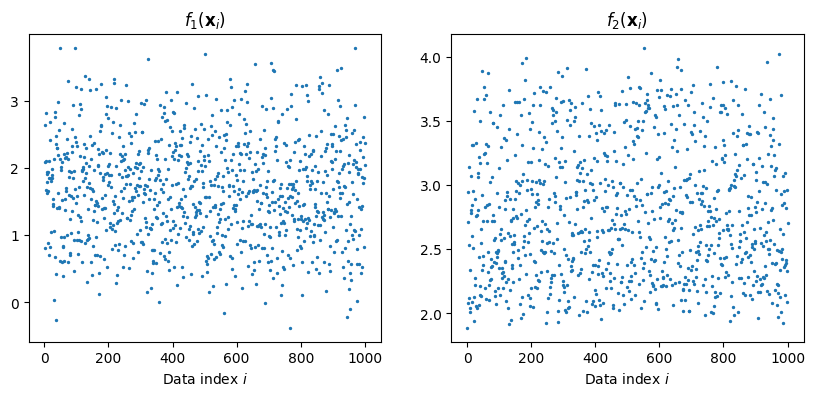

Class 0: 128 samples
Class 1: 342 samples
Class 2: 353 samples
Class 3: 177 samples

Training set: 713 samples
Testing set: 287 samples


In [17]:
data_train, data_test = generate_toy_data(feature_dim=4, sample_num=1000, seed=SEED)

이 간단한 데이터셋은 총 1000개의 샘플이 타겟 0 ~ 3의 총 4개의 클래스로 분류되어 있고,

713개의 training data, 287개의 testing data로 나누어져 있다.

다음은 `data~.y` 에 담겨있는 target class의 정보의 one-hot 인코딩 결과이다.

In [18]:
print(f"Y = \n{data_train.y_onehot}")

Y = 
tensor([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


이제, 두 개의 레이어를 갖는 간단한 MLP 모델을 만들어보자.

첫 번째 레이어는 $d$-dim input을 임의의 hidden channel $H$로 바꾼 뒤 sigmoid ($\Phi(x)$) 를 취하고, 두 번째 은닉 레이어는 8차원을 4차원으로 내린 뒤 softmax ($\Psi(x)$) 를 취해 output으로 내보내는 간단한 모델이다.

각 레이어 변환을 $\mathcal{L}_l$, 그것의 파라미터들 $\{\mathbf{W}_l,\mathbf{b}_l\}$ 을 $\mathbf{p}_l$ 로 놓은 뒤 수식으로 표현하면,

\begin{align}
\mathbf{x}_1 & = \mathcal{L}_0(\mathbf{x}_0;\mathbf{p}_0) = \Phi(\mathbf{x}_0\mathbf{W}_0 + \mathbf{b}_0) \\
\mathbf{x}_{\mathrm{out}} & = \mathcal{L}_1(\mathbf{x}_1;\mathbf{p}_1) = \Psi(\mathbf{x}_1\mathbf{W}_1 + \mathbf{b}_1),\qquad \mathrm{W}_0\in\mathbb{R}^{d\times H},\;\mathrm{W}_1\in\mathbb{R}^{H\times d},\;\mathrm{and}\; \mathrm{b}_0\in\mathbb{R}^{H},\; \mathrm{b}_1\in\mathbb{R}^{d}
\end{align}

이 되고, 통틀어 몇백 개 남짓의 parameter를 갖는 아주 미니멀한 크기다.

이제, [참고자료](https://github.com/hkyoon94/ML)에 계산해 놓은 일반적 $L+1$개 레이어에 대한 역전파 식을 바탕으로, 이 간단한 2-레이어 MLP의 역전파는 다음 두 가지만 계산해주면 된다:

\begin{align}
  \frac{\partial}{\partial\mathbf{p}_1}\mathbf{x}_{\mathrm{out}} & = \frac{\partial\mathcal{L}_1(\mathbf{x}_1;\mathbf{p}_1) }{\partial\mathbf{p}_1} \\
  & = \frac{\partial}{\partial\mathbf{h_1}}\Psi(\mathbf{h_1})\;\frac{\partial}{\partial \mathbf{p_1}}\mathbf{h}_1(\mathbf{x}_1;\mathbf{p}_1), \quad\cdots\;\mathrm{(E)} \\
  \frac{\partial}{\partial\mathbf{p}_{0}}\mathbf{x}_{\mathrm{out}} & = \frac{\partial\mathcal{L}_1(\mathbf{x}_1;\mathbf{p}_1) }{\partial\mathbf{x}_1}\frac{\partial\mathcal{L}_{0}(\mathbf{x}_{0};\mathbf{p}_{0}) }{\partial\mathbf{p}_{0}} \\
  & =\frac{\partial}{\partial\mathbf{h_1}}\Psi(\mathbf{h_1})\;\frac{\partial}{\partial \mathbf{x_1}}\mathbf{h}_1(\mathbf{x}_1;\mathbf{p}_1)\;\frac{\partial}{\partial\mathbf{h_0}}\Phi(\mathbf{h_0})\;\frac{\partial}{\partial \mathbf{p_0}}\mathbf{h}_0(\mathbf{x}_0;\mathbf{p}_0). \quad\cdots\;\mathrm{(F)}\\
\end{align}

위에 계산해 놓은 대로, 각 도함수 텐서들은 다음과 같다:

In [5]:
# Jacobian (A)
def get_dL_dh(h: T_) -> T_:
    dphi_dh = torch.zeros(h.shape[0], h.shape[1], h.shape[0], h.shape[1])
    for b in range(dphi_dh.shape[0]):
        sig_h = h[b].sigmoid()
        phiprime = sig_h * (1 - sig_h)
        for i in range(dphi_dh.shape[1]):
            dphi_dh[b, i, b, i] = phiprime[i]
    return dphi_dh

# Jacobian (B)
def get_dh_dx(h: T_, x: T_, W: T_) -> T_:
    dh_dx = torch.zeros(h.shape[0], h.shape[1], x.shape[0], x.shape[1])
    for b in range(dh_dx.shape[0]):
        dh_dx[b, :, b, :] = W.T
    return dh_dx

# Jacobian (C)
def get_dh_dW(h: T_, x: T_, W: T_) -> T_:
    dh_dW = torch.zeros(h.shape[0], h.shape[1], W.shape[0], W.shape[1])
    for b in range(dh_dW.shape[0]):
        for i in range(dh_dW.shape[1]):
            dh_dW[b, i, :, i] = x[b]
    return dh_dW

# Jacobian (D)
def get_dh_db(h: T_, x: T_, W: T_) -> T_:
    dh_db = torch.zeros(h.shape[0], h.shape[1], h.shape[1])
    for b in range(dh_db.shape[0]):
        for i in range(dh_db.shape[1]):
            dh_db[b, i, i] = 1
    return dh_db

마지막으로, Cross Entropy의 도함수는 softmax 함수와 합성하여 $\Psi$를 취하기 전의 변수인 $\mathbf{h}_1$ 에 대해 구해야 division by 0 문제를 피할 수 있게 되며, 수식으로도 훨씬 간단히

$$ \frac{\partial}{\partial\mathbf{h}} \mathrm{CEloss}(\Psi(\mathbf{h});\mathbf{y})  = \mathrm{y}-\mathrm{h}$$

로 표현되어 역전파가 더욱 안정적으로 이루어지게 된다. 코드로는 간단히 다음과 같다.

In [6]:
def get_dLoss_dh(y: T_, h: T_, N: int) -> T_:
    return (h - y) / N

먼저 모델을 임의로 initialize 시킨 후 test set에 대한 accuracy 를 구해 보면,

In [7]:
dim = 4
hidden_size = 8

w0, b0 = torch.randn(dim, hidden_size), torch.randn(hidden_size)
w1, b1 = torch.randn(hidden_size, dim), torch.randn(dim)

criterion = torch.nn.CrossEntropyLoss(reduction="mean")

# FORWARD PASS
h0_test = data_test.x.mm(w0) + b0
x1_test = h0_test.sigmoid()
h1_test = x1_test.mm(w1) + b1

pred_test = h1_test.softmax(dim=-1).argmax(dim=-1)
test_correct = pred_test == data_test.y
test_acc = int(test_correct.sum()) / data_test.num_samples

print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.3380


아직은 잘 분류를 하지 못하는 모습을 보인다.

`DataLoader`를 정의하고, 위 Jacobi 텐서들을 사용해 실제 훈련에 들어가 보자.

이 문서 내 실험들의 세팅은 아래와 같이 통일한다:

In [8]:
# hyper-parameters
dim = 4
hidden_size = 64
bsz = 128
num_epochs = 200
lr = 0.05

# initializing parameters
w0, b0 = torch.randn(dim, hidden_size), torch.randn(hidden_size)
w1, b1 = torch.randn(hidden_size, dim), torch.randn(dim)

criterion = torch.nn.CrossEntropyLoss(reduction="mean")
train_loader = DataLoader(data_train, bsz=bsz)
train_loader.shuffle()

이제 위의 식들을 참고하여 Jacobian들의 수축을 직접 구현하며 신경망을 학습시키는 코드는 다음과 같다:

In [21]:
train_loss, test_loss, test_acc = [], [], []

backward_time = 0.0
for epoch in tqdm(range(num_epochs)):
    loss_sum = 0

    for step, (x_train, y_train, y_train_onehot) in enumerate(train_loader):
        # FORWARD PASS
        h0 = x_train.mm(w0) + b0
        x1 = h0.sigmoid()
        h1 = x1.mm(w1) + b1
        h1_hat = h1.softmax(dim=-1)
        loss = criterion.forward(h1, y_train_onehot)

        ################## BACKWARD PASS ###################
        st = time()

        dL0_dh0 = get_dL_dh(h0)
        dh0_dw0 = get_dh_dW(h0, x_train, w0)
        dh0_db0 = get_dh_db(h0, x_train, w0)

        dL1_dh1 = get_dL_dh(h1)
        dh1_dx1 = get_dh_dx(h1, x1, w1)
        dh1_dw1 = get_dh_dW(h1, x1, w1)
        dh1_db1 = get_dh_db(h1, x1, w1)

        dL_dh1 = get_dLoss_dh(y_train_onehot, h1_hat, len(x_train))

        # contracting all Jacobi-tensors
        # left: contravariant / right: covariant dimensions
        dL_dw1 = torch.einsum("bi, bijk -> jk", dL_dh1, dh1_dw1)
        dL_db1 = torch.einsum("bi, bij -> j", dL_dh1, dh1_db1)
        mid_grad = torch.einsum(
            "bi, bicj-> cj",
            torch.einsum("bi, bicj -> cj", dL_dh1, dh1_dx1),
            dL0_dh0,
        )
        dL_dw0 = torch.einsum("bi, bijk -> jk", mid_grad, dh0_dw0)
        dL_db0 = torch.einsum("bi, bij -> j", mid_grad, dh0_db0)

        ft = time()

        # PARAMETER UPDATE
        w1 = w1 - lr * dL_dw1
        w0 = w0 - lr * dL_dw0
        b1 = b1 - lr * dL_db1
        b0 = b0 - lr * dL_db0

        loss_sum += loss.item() * len(x_train)
        backward_time += (ft - st)

    train_loss.append(loss_sum / data_train.num_samples)

    # EVALUATING
    h0_test = data_test.x.mm(w0) + b0
    x1_test = h0_test.sigmoid()
    h1_test = x1_test.mm(w1) + b1
    test_loss.append(criterion.forward(h1_test, data_test.y_onehot))

    # computing accuracy
    pred_test = h1_test.softmax(dim=-1).argmax(dim=-1)
    test_correct = pred_test == data_test.y
    test_acc.append(test_correct.sum() / data_test.num_samples)

print(
    f"RESULT | Accuracy: {test_acc[-1]:.4f}, "
    f"backward elsapsed total {backward_time:.2f} seconds "
    f"({backward_time / (step * num_epochs):.6f}sec/it)"
)

 34%|███▍      | 69/200 [01:48<03:26,  1.58s/it]


KeyboardInterrupt: 

약 5분 정도의 긴 시간이 소요됐고, 한 개의 mini-batch에 대한 backward를 수행하는 데에는 약 0.3초라는... 엄청난 시간이 걸렸다.
예상은 했지만, 그래도 너무 오래 걸린 것 같아 원인을 분석해보자면,

- 위의 (A), (B), 등의 grad를 직접 실체화하는 함수에서도 볼 수 있듯이, **Jacobi 텐서는 굉장히 sparse 하다**.

따라서, 해당 지점의 함숫값들을 이용해 Jacobi 텐서간의 연산을 직접 수행하면, 불필요한 연산이 너무 증가하게 된다. 따라서, `PyTorch`는 이 연산을 명시적으로 계산하는 대신, VJP를 사용하여 implicit하고 효율적으로 계산한다. 다음 단원에서 이를 구현해보겠다.

훈련은 다음과 같이 steepest descent가 잘 적용된 것을 볼 수 있다.

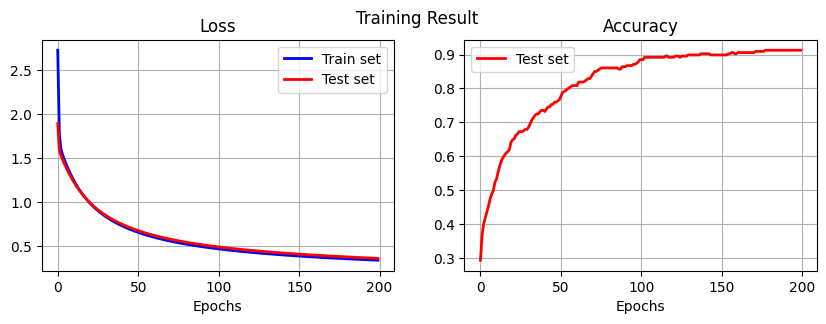

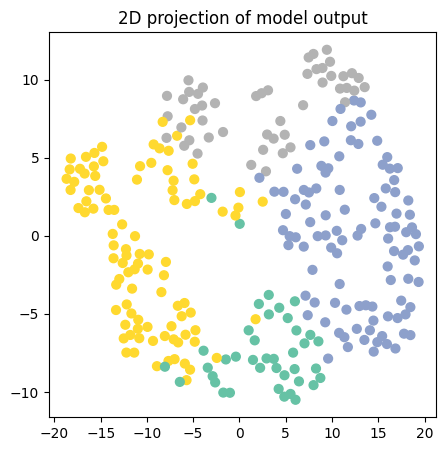

In [20]:
visualize_results(train_loss, test_loss, test_acc, last_hiddens=h1_test, labels=data_test.y)

---

## 2. Computational Graph와 Vector-Jacobi Product(VJP)를 이용해 역전파 최적화하기

직전에 확인했듯이, 직접 Jacobi 행렬을 만들어 chain-rule을 실시해 미분을 하게 되면 컴퓨팅 효율이 매우 좋지 않다.

**우리는 미분계수를 구해야 할 목적함수의 형태를(`MSELoss`, `CELoss` 등) 이미 알고 있으므로, 이를 이용해 결괏값으로부터 거꾸로 Jacobi 수축을 전파하는 것이 바로 auto-diff의 핵심이다.**

- #### 연산 그래프 확인 및 Common Subgraph 추출

`torchviz` 패키지를 사용해, 현재 사용중인 MLP 모델의 파라미터들이 어떠한 구조로 계산에 참여하여 최종적인 손실값을 도출하는지 연산 그래프(computational graph)로 확인할 수 있다.

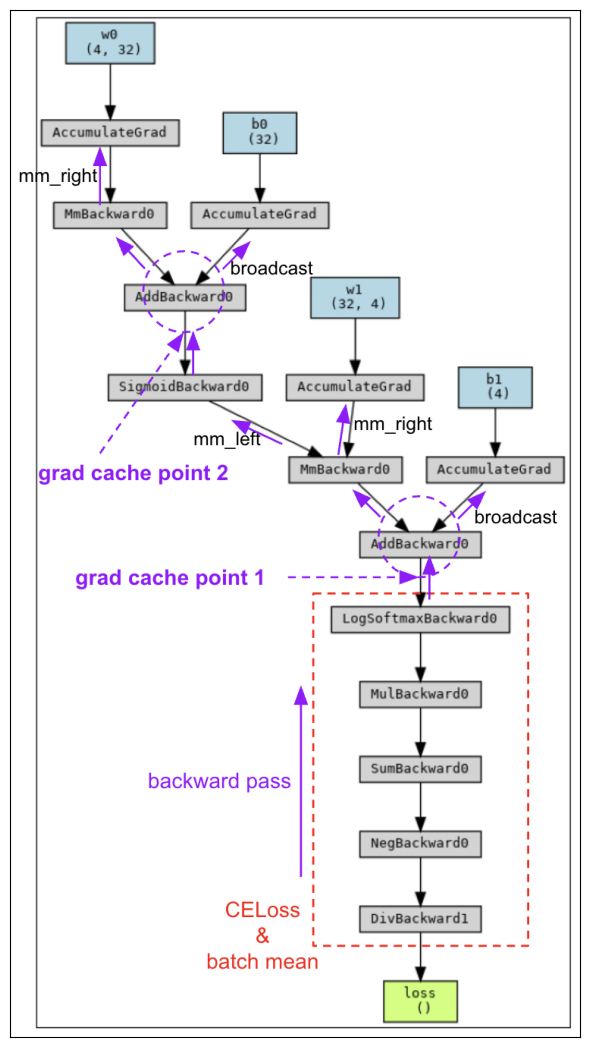

In [10]:
# 가중치들을 requires_grad=True로 설정 후 forward (leaf tensor로 생성)
w0, b0 = torch.randn(4, 32, requires_grad=True), torch.randn(32, requires_grad=True)
w1, b1 = torch.randn(32, 4, requires_grad=True), torch.randn(4, requires_grad=True)

# FORWARD PASS
h0 = data_test.x.mm(w0) + b0
x1 = h0.sigmoid()
h1 = x1.mm(w1) + b1
loss = torch.nn.CrossEntropyLoss().forward(h1, data_test.y_onehot)

# Loading the annotated computational graph
draw_computational_graph(
    loss,
    params={"loss": loss, "w0": w0, "b0": b0, "w1": w1, "b1": b1},
    save_path="./assets/graph"
)

그래프를 보면, 마치 나무 모양처럼 scalar인 `loss`가 뿌리를 이루고, 연산을 거슬러 올라가면서 서로 다른 파라미터들 (푸른색 변수들, 즉, `requires_grad=True`인 텐서들)이 연산에 참여하는 과정이 한눈에 들어온다. 이 파라미터들은 항상 뿌리 가장 반대편의 잎사귀 부분에 위치하게 된다.

따라서 **푸른색으로 표시되어 있는 이 변수들을 leaf 텐서**라고 하며, `requires_grad=False`인 일반 상수 파라미터나 중간 연산 산출물들은 non-leaf 텐서가 된다.

>1. 연산 그래프는, 언제나 unidirectional directed graph이며, 보통 입력 데이터 $\mathbf{x}$ 가 연산되는 방향을 forward pass, 그 반대 방향을 backward pass라고 한다.
>
>2. 그래프의 각 노드는 "함수" 혹은 "연산"으로 볼 수 있다. `forward`시 그래프로 들어오는 값들은, 노드마다 정의된 함수 연산이 행해진 후 다음 노드로 이동한다. 노드 입력의 갯수는, 연산에 참여한 leaf-텐서의 갯수이다. 즉, 3개의 edge를 갖는 path는, "3개의 고유 파라미터가 참여한 연산"으로 볼 수 있다.
>
>3. 합성함수를 미분할 경우, 가장 많이 합성된 변수로부터 미분해가며 곱하는 것이 일반적이며, **이는 연산 그래프 상에서 gradient가 backward 방향으로 곱해져 가는 것으로 이해할 수 있다.**
>
>4. backward pass시 상위 노드에게서 출발한 gradient가 특정 연산 $\mathbf{f}$를 수행하는 노드를 지나 다음 노드에게 전달될 gradient는 항상 다음과 같은 형태의 Jacobian product로 계산할 수 있다(이것이 VJP이다). $\mathbf{g}_{\text{in}}$를 입력 gradient라고 하면:
>
>\begin{align} \mathbf{g}_{\mathrm{out}_{j_1\dots j_m}} = \mathbf{g}_{{\text{in}}_{k_1\dots,k_l}} \left.\frac{\partial\mathbf{f}(\mathbf{x})^{k_1,\dots k_l}}{\partial\mathbf{x}_{j_1\dots j_m}}\right|_{\mathbf{x}=\mathbf{x}_*} \end{align}
>
>$\quad\quad$ 이 때, $\mathbf{x}_*$는 forward 시의 해당 노드에서의 $\mathbf{x}$값이다.
>
>5. *backward pass의 분기점을 공유하는 leaf 텐서들은, 해당 분기점 전을 공유하는 common subgraph를 가질 수 있다.* 따라서, 이르 분석하여 분기점으로 흘러 들어오는 gradient를 캐싱해 두면, 그 분기점들을 공유하는 leaf-tensor들의 gradient를 계산할 때 효율적으로 계산할 수 있다.

여기서는

- $\mathbf{W}_1$과 $\mathbf{b}_1$, 그리고
- $\mathbf{W}_0$와 $\mathbf{b}_0$ 의 사이에

명확한 분기점을 볼 수 있고, 따라서 해당 부분의 grad 값을 backward시 캐싱하면, 좋은 효율을 얻을 수 있다. 이는 앞서 계산한 수학적인 레이어 역전파 식 구조에서도 볼 수 있다.

- ### 연산별 VJP의 유도 및 구현

앞서 사용한 MLP 모델의 각 레이어별 VJP를 계산하려면, 단지 위의 $Eq. (1)$처럼 흘러들어오는 gradient의 covariant 차원을 현재 node의 Jacobian의 contravariant 차원과 수축해주기만 하면 된다.

즉, 다음과 같다:

\begin{align}
\mathbf{g}_{bi}\left(\frac{\partial}{\partial\mathbf{h}}\Phi(\mathbf{h})\right)^{bi}_{b'j} & = \mathbf{g}_{bi}\delta^{b}_{b'}\phi(h^{ij})(1-\phi(h^{ij}))\delta^i_j  = \mathbf{g}_{b'j}\phi(h^{b'j})(1-\phi(h^{b'j}))\quad\cdots\;\mathrm{(A)} \\
\mathbf{g}_{bi}\left(\frac{\partial\mathbf{h}}{\partial\mathbf{x}}\right)^{bi}_{b'j} & = \mathbf{g}_{bi}\delta^b_{b'}W^{ji} = \mathbf{g}_{b'i}W^{ji}\quad\cdots\;\mathrm{(B)}\\
\mathbf{g}_{bi}\left(\frac{\partial\mathbf{h}}{\partial\mathbf{W}}\right)^{bi}_{jk} & = \mathbf{g}_{bi}\delta^i_k x^{b}_{j} = \mathbf{g}_{bk} x^b_j\quad\cdots\;\mathrm{(C)}\\
\mathbf{g}_{bi}\left(\frac{\partial\mathbf{h}}{\partial\mathbf{b}}\right)^{bi}_j & = \mathbf{g}_{bi}\delta^i_j = \mathbf{g}_{bj} \quad\cdots\;\mathrm{(D)}
\end{align}

앞서 유도한 `CrossEntropyLoss & Softmax` with mean의 derivative와 같이 사용하면, 아래와 같이 VJP를 구현할 수 있다.

In [11]:
def ce_mean_backward(y: T_, h: T_, N: int) -> T_:
    return (h - y) / N

# From (A)
def sigmoid_backward(grad: T_, x: T_) -> T_:
    sig_x = torch.sigmoid(x)
    return torch.einsum("bi, bi -> bi", grad, sig_x * (1 - sig_x))

# From (B)
def mmul_left_backward(grad: T_, x: T_) -> T_:
    return torch.einsum("bj, ij -> bi", grad, x)

# From (C)
def mmul_right_backward(grad: T_, x: T_) -> T_:
    return torch.einsum("bj, bi -> ij", grad, x)

# From (D)
def add_broadcast_backward(grad: T_, x: T_ | None = None) -> T_:
    return torch.einsum("bi -> i", grad)

def add_backward(grad: T_, x: T_ | None = None) -> T_:
    return grad

100%|██████████| 200/200 [00:00<00:00, 347.25it/s]


RESULT | Accuracy: 0.9094, backward elsapsed total 0.27 seconds (0.000274sec/it)


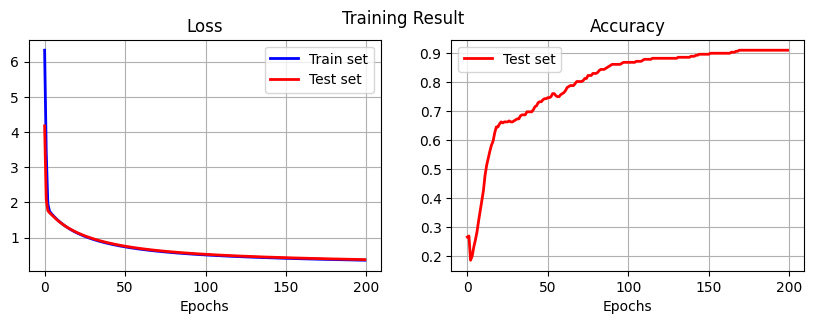

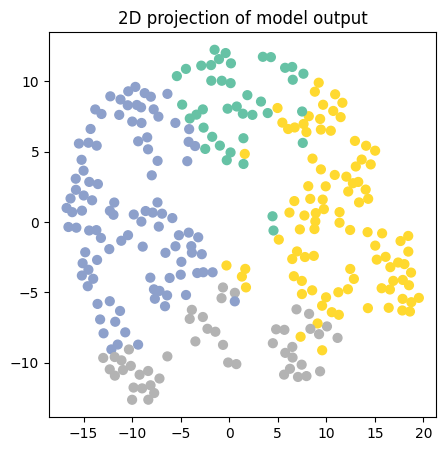

In [22]:
# hyper-parameters
dim = 4
hidden_size = 64
bsz = 128
num_epochs = 200
lr = 0.05

# initializing parameters
w0, b0 = torch.randn(dim, hidden_size), torch.randn(hidden_size)
w1, b1 = torch.randn(hidden_size, dim), torch.randn(dim)
criterion = torch.nn.CrossEntropyLoss(reduction="mean")

train_loader = DataLoader(data_train, bsz=bsz)
train_loader.shuffle()

train_loss, test_loss, test_acc = [], [], []

backward_time = 0.0
for epoch in tqdm(range(num_epochs)):
    loss_sum = 0
    
    for step, (x_train, y_train, y_train_onehot) in enumerate(train_loader):
        # FORWARD PASS
        h0 = x_train.mm(w0) + b0
        x1 = h0.sigmoid()
        h1 = x1.mm(w1) + b1
        h_hat = h1.softmax(dim=-1)  # for backward
        loss = criterion.forward(h1, y_train_onehot)

        ################## BACKWARD PASS ###################
        st = time()

        # grad cache point 1
        ce_grad = ce_mean_backward(y_train_onehot, h_hat, len(x_train))
        dL_db1 = add_broadcast_backward(ce_grad, None)
        dL_dw1 = mmul_right_backward(add_backward(ce_grad, None), x1)

        # grad cache point 2
        mid_grad = sigmoid_backward(mmul_left_backward(add_backward(ce_grad, None), w1), h0)
        dL_db0 = add_broadcast_backward(mid_grad, None)
        dL_dw0 = mmul_right_backward(add_backward(mid_grad, None), x_train)

        ft = time()

        # PARAMETER UPDATE
        w1 = w1 - lr * dL_dw1
        w0 = w0 - lr * dL_dw0
        b1 = b1 - lr * dL_db1
        b0 = b0 - lr * dL_db0

        loss_sum += loss * len(x_train)
        backward_time += (ft - st)

    train_loss.append(loss_sum / data_train.num_samples)

    # EVALUATING
    h0_test = data_test.x.mm(w0) + b0
    x1_test = h0_test.sigmoid()
    h1_test = x1_test.mm(w1) + b1
    test_loss.append(criterion.forward(h1_test, data_test.y_onehot))

    # computing accuracy
    pred_test = h1_test.softmax(dim=-1).argmax(dim=-1)
    test_correct = pred_test == data_test.y
    test_acc.append(test_correct.sum() / data_test.num_samples)

print(
    f"RESULT | Accuracy: {test_acc[-1]:.4f}, "
    f"backward elsapsed total {backward_time:.2f} seconds "
    f"({backward_time / (step * num_epochs):.6f}sec/it)"
)

visualize_results(train_loss, test_loss, test_acc, last_hiddens=h1_test, labels=data_test.y)

- ### PyTorch의 Autograd & SGD와의 성능 비교

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 311.96it/s]


RESULT | Accuracy: 0.9129, backward elsapsed total 0.23 seconds (0.000226sec/it)


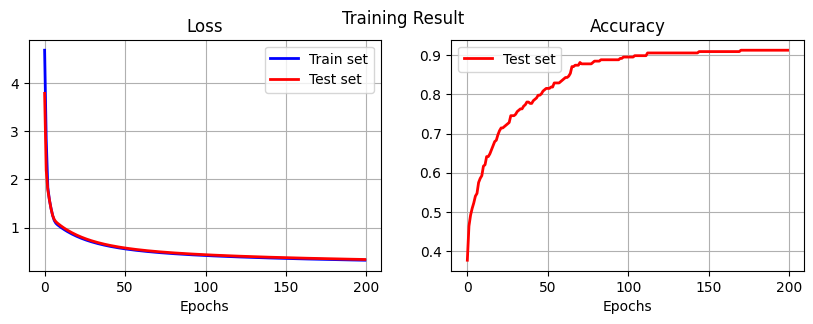

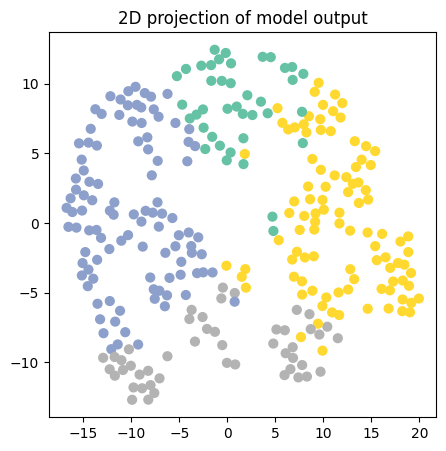

In [24]:
# hyper-parameters
dim = 4
hidden_size = 64
bsz = 128
num_epochs = 200
lr = 0.05


# PyTorch Model
class FeedForward(torch.nn.Module):
    def __init__(self, dim: int, hidden_size: int):
        super().__init__()
        self.w0 = torch.nn.Parameter(torch.randn(dim, hidden_size).float())
        self.b0 = torch.nn.Parameter(torch.randn(hidden_size).float())
        self.w1 = torch.nn.Parameter(torch.randn(hidden_size, dim).float())
        self.b1 = torch.nn.Parameter(torch.randn(dim).float())

    def forward(self, x: T_) -> T_:
        x = x.mm(self.w0) + self.b0
        x = x.sigmoid()
        x = x.mm(self.w1) + self.b1
        return x


model = FeedForward(dim=dim, hidden_size=hidden_size)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
criterion = torch.nn.CrossEntropyLoss(reduction="mean")

train_loader = DataLoader(data_train, bsz=bsz)
train_loader.shuffle()

train_loss, test_loss, test_acc = [], [], []

backward_time = 0.0
for epoch in tqdm(range(num_epochs)):
    model.train()
    loss_sum = 0

    for step, (x_train, y_train, y_train_onehot) in enumerate(train_loader):
        optimizer.zero_grad()
        out = model.forward(x_train)
        loss = criterion.forward(out, y_train_onehot)

        ##### BACKWARD PASS #####
        backward_st = time()
        loss.backward()
        backward_ft = time()

        optimizer.step()

        loss_sum += loss.item() * len(x_train)
        backward_time += (backward_ft - backward_st)

    train_loss.append(loss_sum / data_train.num_samples)

    # EVALUATING
    model.eval()
    test_out = model.forward(data_test.x)
    test_loss.append(criterion.forward(test_out, data_test.y_onehot).item())

    # computing accuracy
    pred_test = torch.softmax(test_out, dim=-1).argmax(dim=-1)
    test_correct = pred_test == data_test.y
    test_acc.append((test_correct.sum() / data_test.num_samples).item())

print(
    f"RESULT | Accuracy: {test_acc[-1]:.4f}, "
    f"backward elsapsed total {backward_time:.2f} seconds "
    f"({backward_time / (step * num_epochs):.6f}sec/it)"
)

visualize_results(train_loss, test_loss, test_acc, last_hiddens=h1_test, labels=data_test.y)

---

## 3. C++ 소스를 작성하여 역전파 성능 최적화하기

현재까지는 원리 위주의 구현을 통해, 순수 Python & PyTorch의 `einsum`을 주로 사용해 backward pass를 수동으로 진행해보았다.

이제 PyTorch 의존 없이 저수준 커널을 직접 작성하여 backward pass를 위한 VJP 루틴들을 구현하고 이를 Python에 바인딩하여 컴퓨팅하는 작업으로 마무리하려고 한다.

'''

In [19]:
import build.libcpp as backwardlib

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 468.00it/s]


RESULT | Accuracy: 0.9094, backward elsapsed total 0.16 seconds (0.000155sec/it)


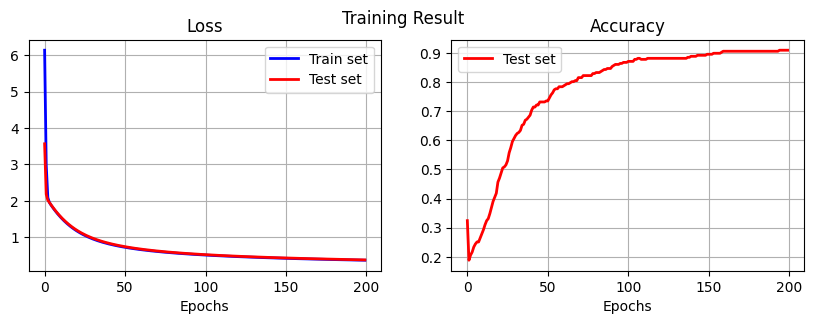

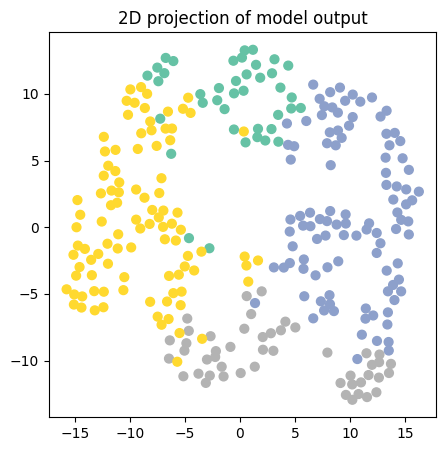

In [20]:
# hyper-parameters
dim = 4
hidden_size = 64
bsz = 128
num_epochs = 200
lr = 0.05

# initializing parameters
w0, b0 = torch.randn(dim, hidden_size), torch.randn(hidden_size)
w1, b1 = torch.randn(hidden_size, dim), torch.randn(dim)
criterion = torch.nn.CrossEntropyLoss(reduction="mean")

train_loader = DataLoader(data_train, bsz=bsz)
train_loader.shuffle()

train_loss, test_loss, test_acc = [], [], []

backward_time = 0.0
for epoch in tqdm(range(num_epochs)):
    loss_sum = 0

    for step, (x_train, y_train, y_train_onehot) in enumerate(train_loader):
        # FORWARD PASS
        h0 = x_train.mm(w0) + b0
        x1 = h0.sigmoid()
        h1 = x1.mm(w1) + b1
        h_hat = h1.softmax(dim=-1)
        loss = criterion.forward(h1, y_train_onehot)

        ################## BACKWARD PASS ###################
        st = time()

        ce_grad = backwardlib.ce_softmax_mean_backward(y_train_onehot, h_hat, len(x_train))
        dL_db1 = backwardlib.add_broadcast_backward(ce_grad)
        dL_dw1 = backwardlib.mmul_right_backward(ce_grad, x1)
        mid_grad = backwardlib.sigmoid_backward(
            backwardlib.mmul_left_backward(ce_grad, w1), h0
        )
        dL_db0 = backwardlib.add_broadcast_backward(mid_grad)
        dL_dw0 = backwardlib.mmul_right_backward(mid_grad, x_train)

        ft = time()

        # PARAMETER UPDATE
        w1 = w1 - lr * dL_dw1
        w0 = w0 - lr * dL_dw0
        b1 = b1 - lr * dL_db1
        b0 = b0 - lr * dL_db0

        loss_sum += loss.item() * len(x_train)
        backward_time += (ft - st)

    train_loss.append(loss_sum / data_train.num_samples)

    # EVALUATING
    h0_test = data_test.x.mm(w0) + b0
    x1_test = h0_test.sigmoid()
    h1_test = x1_test.mm(w1) + b1
    test_loss.append(criterion.forward(h1_test, data_test.y_onehot))

    # computing accuracy
    pred_test = h1_test.softmax(dim=-1).argmax(dim=-1)
    test_correct = pred_test == data_test.y
    test_acc.append(test_correct.sum() / data_test.num_samples)

print(
    f"RESULT | Accuracy: {test_acc[-1]:.4f}, "
    f"backward elsapsed total {backward_time:.2f} seconds "
    f"({backward_time / (step * num_epochs):.6f}sec/it)"
)

visualize_results(train_loss, test_loss, test_acc, last_hiddens=h1_test, labels=data_test.y)

---

## 4. 결과 비교

1. Jacobian 직접 수축
2. 